In [160]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import plot_decision_boundary
from torchmetrics import Accuracy, ConfusionMatrix, Precision

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]], device='cuda:0') tensor([3, 2, 2, 1, 1], device='cuda:0')


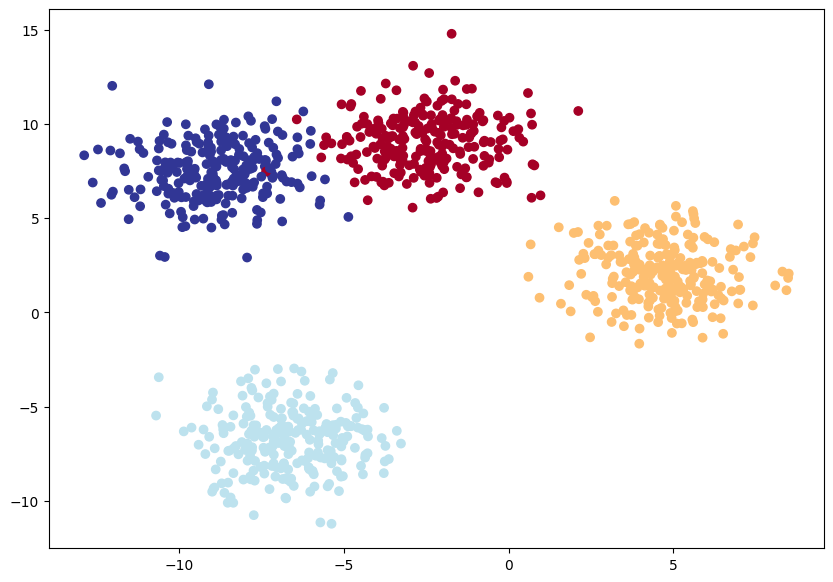

In [24]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,  # X features
                            centers=NUM_CLASSES,  # y labels
                            # give the clusters a little shake up (try changing this to 1.0, the default)
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(device)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob.cpu()[:, 0], X_blob.cpu()[:, 1], c=y_blob.cpu(), cmap=plt.cm.RdYlBu)

In [8]:
X_blob_train.shape

torch.Size([800, 2])

In [9]:
circles = pd.DataFrame({"X1": X_blob[:, 0],
                        "X2": X_blob[:, 1],
                        "label": y_blob})
circles.head(10)

,X1,X2,label
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766101,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1
5,-6.794107,-6.477221,2
6,5.210176,2.889048,1
7,-5.505136,-6.360377,2
8,-6.543756,-4.833899,2
9,6.449642,0.747766,1


In [10]:
circles.label.value_counts()

label
3    250
2    250
1    250
0    250
Name: count, dtype: int64

In [25]:
len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test), X_blob_train.device

(800, 200, 800, 200, device(type='cuda', index=0))

### The Model

In [132]:
class BlobsModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES):
        super().__init__()
        self.layers = nn.Sequential(
                        nn.Linear(in_features=NUM_FEATURES, out_features=10),
                        # nn.ReLU(),
                        nn.Linear(in_features=10, out_features=10),
                        # nn.ReLU(),
                        nn.Linear(in_features=10, out_features=NUM_CLASSES)

                    )
    
    def forward(self, x):
        return self.layers(x)
    

In [133]:
blobs_model = BlobsModel(NUM_FEATURES, NUM_CLASSES)
blobs_model.to(device)

BlobsModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

### Training HyperParameters

In [134]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=blobs_model.parameters(), lr=0.1)

In [135]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [142]:
y_logits = blobs_model(X_blob_test)[:5]

In [143]:
y_logits.squeeze(), y_logits.squeeze(
).shape, y_logits.shape, torch.argmax(y_logits, dim=1)

(tensor([[-0.4636,  0.5324,  0.1829, -0.2480],
         [ 0.8062,  3.0983,  0.5159, -0.8397],
         [ 0.6574, -1.0975, -0.5037,  0.2106],
         [-0.3592, -0.2018, -0.0276, -0.0586],
         [ 0.0107,  2.7798,  0.6318, -0.7937]], device='cuda:0',
        grad_fn=<SqueezeBackward0>),
 torch.Size([5, 4]),
 torch.Size([5, 4]),
 tensor([1, 1, 0, 2, 1], device='cuda:0'))

In [130]:
y_logits

tensor([[ 0.2278,  0.3711,  0.8627, -0.3775],
        [-0.1974,  0.1331,  0.1715, -0.1909],
        [ 0.0566,  0.1291,  0.0878, -0.1532],
        [ 0.0073,  0.1208,  0.5334, -0.3750],
        [-0.0646,  0.5400,  0.5424, -0.4671]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [144]:
y_blob_train[:5], F.softmax(y_logits, dim=1).argmax(dim=1)

(tensor([1, 0, 2, 2, 0], device='cuda:0'),
 tensor([1, 1, 0, 2, 1], device='cuda:0'))

In [108]:
accuracy_fn(y_blob_train[:5], torch.argmax(y_logits, dim=1))

20.0

In [74]:
first_5 = y_blob_test[:5]
# first_5.unsqueeze(dim=1)

In [76]:
first_5, first_5.shape

(tensor([1, 3, 2, 1, 0], device='cuda:0'), torch.Size([5]))

In [90]:
probs = F.softmax(input=y_logits, dim=1)

In [98]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0], device='cuda:0')

In [94]:
torch.argmax(probs, dim=1)

tensor([1, 2, 1, 1, 3], device='cuda:0')

### Training our Model

In [146]:
torch.manual_seed(42)

epochs = 1801

for epoch in range(epochs):
    blobs_model.train()
    y_logits = blobs_model(X_blob_train)
    max_logits = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, max_logits)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blobs_model.eval()
    with torch.inference_mode():
        test_logits = blobs_model(X_blob_test)
        max_test_logits = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, max_test_logits)

    if epoch % 200 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.02212, Accuracy: 99.50% | Test loss: 0.01068, Test acc: 99.50%
Epoch: 200 | Loss: 0.02178, Accuracy: 99.50% | Test loss: 0.01033, Test acc: 99.50%
Epoch: 400 | Loss: 0.02146, Accuracy: 99.50% | Test loss: 0.01000, Test acc: 99.50%
Epoch: 600 | Loss: 0.02115, Accuracy: 99.50% | Test loss: 0.00967, Test acc: 99.50%
Epoch: 800 | Loss: 0.02085, Accuracy: 99.50% | Test loss: 0.00936, Test acc: 99.50%
Epoch: 1000 | Loss: 0.02056, Accuracy: 99.50% | Test loss: 0.00905, Test acc: 99.50%
Epoch: 1200 | Loss: 0.02028, Accuracy: 99.50% | Test loss: 0.00875, Test acc: 99.50%
Epoch: 1400 | Loss: 0.02002, Accuracy: 99.50% | Test loss: 0.00845, Test acc: 99.50%
Epoch: 1600 | Loss: 0.01976, Accuracy: 99.50% | Test loss: 0.00817, Test acc: 99.50%
Epoch: 1800 | Loss: 0.01952, Accuracy: 99.50% | Test loss: 0.00788, Test acc: 100.00%


### Predicting with our Model

In [149]:
# Make predictions
blobs_model.eval()
with torch.inference_mode():
    y_logits = blobs_model(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  8.8608,  25.1926, -21.5599, -13.8278],
        [ 15.2125, -25.6251,   6.8848,  23.1099],
        [-12.8879, -23.7800,  25.8661,   8.6403],
        [  2.7453,  20.0193, -13.8082, -13.2530],
        [ 20.2857,   7.5694, -18.3182,   3.3261],
        [ 17.3293, -32.4589,   9.8033,  28.6719],
        [-14.5585, -16.4917,  22.3321,   2.9848],
        [ 18.4396,  -1.1176, -11.3502,   8.2593],
        [-11.8310, -35.6315,  32.8046,  17.0548],
        [ 18.7782,   2.1128, -13.6915,   6.2610]], device='cuda:0')

In [150]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


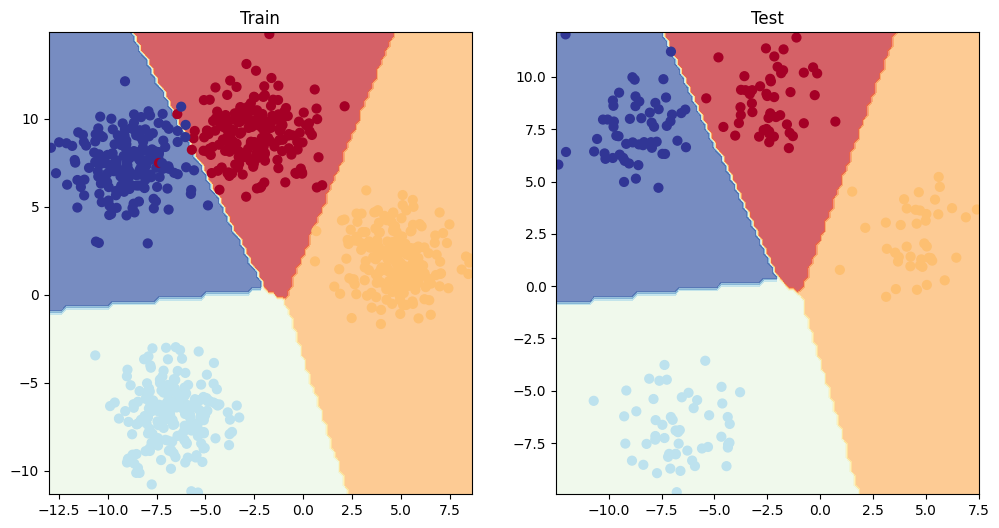

In [153]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blobs_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blobs_model, X_blob_test, y_blob_test)

In [155]:
accuracy_metrics = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

In [157]:
accuracy_metrics(y_preds, y_blob_test)

tensor(1., device='cuda:0')

In [158]:
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=NUM_CLASSES).to(device)

In [159]:
confusion_matrix(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 0,  0,  0, 57]], device='cuda:0')

In [161]:
precision_metrics = Precision(task= 'multiclass', num_classes=NUM_CLASSES).to(device)

In [162]:
precision_metrics(y_preds, y_blob_test)

tensor(1., device='cuda:0')